# Project Details:

* Title: Reboot: Box-Plots for Education
* Team Members: Ayesha Bhimdiwala, JanakiKhatiwada, Sunanda Unni

# Introduction

The **Reboot: Box-Plots for Education** is a data science challenge sponsored by the Education Resource Strategies (ERS). It is an on-going competition which will end in February. 

In this project, we plan to solve a **multi-class-multi-label classification problem** with the goal of attaching canonical labels to the freeform text in budget line items. These labels let ERS understand how schools are spending money and tailor their strategy recommendations to improve outcomes for students, teachers, and administrators.




##  Project Problem

Predict the probability that a certain label from each target category is attached to a budget line item.

## Data  Description

Train data set, "train.csv" has 25 features. Out of these, 2 are numerical and rest are categorical. Also out of 25, 9 are target features.

Following are the features that will be used for building model and predicting probabilities.

  *  FTE float - If an employee, the percentage of full-time that the employee works.
  *  Facility_or_Department - If expenditure is tied to a department/facility, that department/facility.
  *  Function_Description - A description of the function the expenditure was serving.
  *  Fund_Description - A description of the source of the funds.
  *  Job_Title_Description - If this is an employee, a description of that employee's job title.
  *  Location_Description - A description of where the funds were spent.
  *  Object_Description - A description of what the funds were used for.
  *  Position_Extra - Any extra information about the position that we have.
  *  Program_Description - A description of the program that the funds were used for.
  *  SubFund_Description - More detail on Fund_Description
  *  Sub_Object_Description - More detail on Object_Description
  *  Text_1 - Any additional text supplied by the district.
  *  Text_2 - Any additional text supplied by the district.
  *  Text_3 - Any additional text supplied by the district.
  *  Text_4 - Any additional text supplied by the district.
  *  Total float - The total cost of the expenditure.

And these are target features we have to predict probability for labeling each row.

  *  Function
  *  Object_Type
  *  Operating_Status
  *  Position_Type
  *  Pre-K
  *  Reporting
  *  Sharing
  *  Student_type
  *  Use


# ETL Phase

## Prepare the notebook

In [201]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from collections import Counter
from scipy import sparse, stats
from sklearn import preprocessing as prep

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, StratifiedKFold

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.utils import check_array
from time import time

#from fancyimpute import MICE
from statsmodels.imputation.mice import MICEData as md
%matplotlib inline   

In [202]:
from MICE import MiceImputer
import re
from sklearn import preprocessing

In [203]:
%ls -l data/education_reboot/TrainingData.csv

Invalid switch - "education_reboot".


In [204]:
path = os.path.join('data','education_reboot') #make sure you have the same path in your parent directory
path

'data\\education_reboot'

In [205]:
def load_data(datapath,data):
    csv_path = os.path.join(datapath,data)
    df = pd.read_csv(csv_path)
    #df = pd.read_csv(csv_path,index_col=0)
    
  #  print(df.info())
  #  display(df.head())
  #  print()
    return df

In [206]:
train = load_data(path,"TrainingData.csv")
train['index'] = train['Unnamed: 0']

In [207]:
train = train.drop('Unnamed: 0', axis = 1)
train.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1,index
0,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN,134338
1,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES,206341
2,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN,326408
3,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION,364634
4,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION,47683


Looking at the column names i.e. our features, we see there are **Two** numeric features, FTE and TOTAL.

* FTE stands for full-time equivalent(0-100%). To elaborate, if a budget item is associated to an employee, then we have a value between 0 and 1. It tells us the percentage of full-time that the employee works. A value of 1 means the employee works full-time. A value close to 0 means the employee is working either part-time or on contract basis.

* TOTAL stands for the total cost of the expenditure. It tells us how much the budget item costs.



## Exploratory Data Analysis
**Let's explore numeric variables further:**

In [208]:
train.describe()

,FTE,Total,index
count,126071.000000,3.957220e+05,400277.000000
mean,0.426794,1.310586e+04,225186.018537
std,0.573576,3.682254e+05,130025.142718
min,-0.087551,-8.746631e+07,2.000000
25%,0.000792,7.379770e+01,112601.000000
50%,0.130927,4.612300e+02,225243.000000
75%,1.000000,3.652662e+03,337722.000000
max,46.800000,1.297000e+08,450340.000000


We see there are some negative values in the the numeric features. We would have to impute such missing or incorrect values as we cannot have a negative value associated with the percentage of full-time that the employee works or total cost of the expenditure.

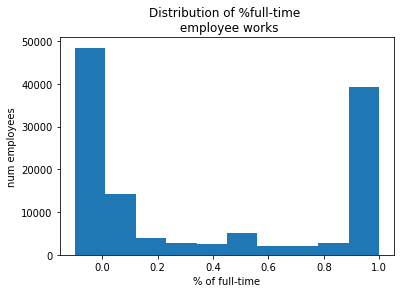

In [209]:
plt.hist(train['FTE'].dropna(),range=[-0.1,1])
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')
plt.show()

From the above plot, we can see that our budgets data favors part-time and contract-based employees as we have more contract employees than full-time employees. 

We have 50k records with negative FTE. Ideally it shouldn’t be negative. This shows that a lot of positions are getting changed and thus resulting in **negative** values. Our strategy would be to normalizing it to 0.

We can assume that contract-based employees are hired for a short-term purpose and that is why they need certain items more frequent than full-time employees who would have such items easily accessible. (NEED to INFER something!)

### Distribution of Categorical Features

Since this data set primarily consists of categorical features, it is very important to look at their distribution. The table below show unique values, count of features, top feature and frequency of top subcategory under each category.

In [210]:
train.describe(include=['O'])

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Text_3,Text_4,Sub_Object_Description,Location_Description,Function_Description,Facility_or_Department,Position_Extra,Program_Description,Fund_Description,Text_1
count,400277,400277,400277,400277,400277,400277,400277,400277,400277,375493,...,109152,53746,91603,162054,342195,53886,264764,304660,202877,292285
unique,37,8,5,3,9,25,11,3,3,602,...,34,244,182,354,687,179,580,421,141,1423
top,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,Regular,Regular Instruction,Extra Duty Pay/Overtime For Support Personnel,School,NON-PROJECT,All Campus Payroll,PROFESSIONAL-INSTRUCTIONAL,GENERAL ELEMENTARY EDUCATION,General Operating Fund,REGULAR INSTRUCTION
freq,86354,203608,254433,257258,223026,102788,97670,306425,343578,47495,...,94462,10762,9159,65524,76890,17697,92136,32829,33467,64896


 Let us look at null values under each category

In [211]:
print(train.isnull().sum())

Function                       0
Use                            0
Sharing                        0
Reporting                      0
Student_Type                   0
Position_Type                  0
Object_Type                    0
Pre_K                          0
Operating_Status               0
Object_Description         24784
Text_2                    312060
SubFund_Description        93422
Job_Title_Description     107534
Text_3                    291125
Text_4                    346531
Sub_Object_Description    308674
Location_Description      238223
FTE                       274206
Function_Description       58082
Facility_or_Department    346391
Position_Extra            135513
Total                       4555
Program_Description        95617
Fund_Description          197400
Text_1                    107992
index                          0
dtype: int64


Converting our Categorical columns datatype from object to categorical, as this will help in the future for pipeline

In [212]:
### post numerical pipeline changes need to check if we can remove these variables, 
### used 3 cells below

cat_list = ['Function','Use','Sharing','Reporting','Student_Type','Position_Type','Object_Type',
              'Pre_K','Operating_Status']

In [213]:
# cat_lab = lambda x: x.astype('category')

# train[cat_list] = train[cat_list].apply(cat_lab,axis=0)

# print(train.dtypes)

In [214]:
np.round(np.sum(train['Total'] < 0)/np.sum(train['Total']),6)

8e-06

So, we see that we have a small percent of negative budgets. Look’s good for now. Later we will impute them.

**Let's see the sub-categories of our target classes**

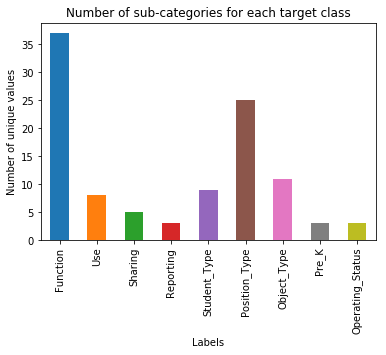

In [215]:
import matplotlib.pyplot as plt

uni_labels = train[cat_list].apply(pd.Series.nunique)

uni_labels.plot(kind='bar')

plt.xlabel('Labels')
plt.ylabel('Number of unique values')
plt.title('Number of sub-categories for each target class')

plt.show()

From the above plot, we see that Function and Position_Type have the highest number of sub-categories while the lowest number of sub-categories are 3 in Operating_Status, Pre_K, and Reporting.

In [216]:
## Let's see if missing Total can be computed based on Job_Title_Description
average_total =train[['Total', 'Job_Title_Description']].groupby(['Job_Title_Description'], as_index = True).mean().sort_values(by = 'Total')
average_total

,Total
Job_Title_Description,
"Dir, Library Media Svcs",-38.695000
"TCHR, K-8 SUB DAY/DAY",-0.580000
INT TEMP EXEC SEC TO THE CEO,-0.550000
SUBSTITUTE GENERAL PREP,-0.330000
CLASSIFIED EDUC CONSUL II,-0.280000
"EDUCATIONAL ASSISTANT, RETIREE",-0.280000
SECURITY OFFICER (EXTERNAL),-0.247500
"TCHR, K-8 LDBD TUTOR-HRLY",-0.162500
ASSOC STRATEGIC IMPLEM OFFICER,0.220000


Let us further explore how the Budget is distributed among different target class

<function matplotlib.pyplot.show>

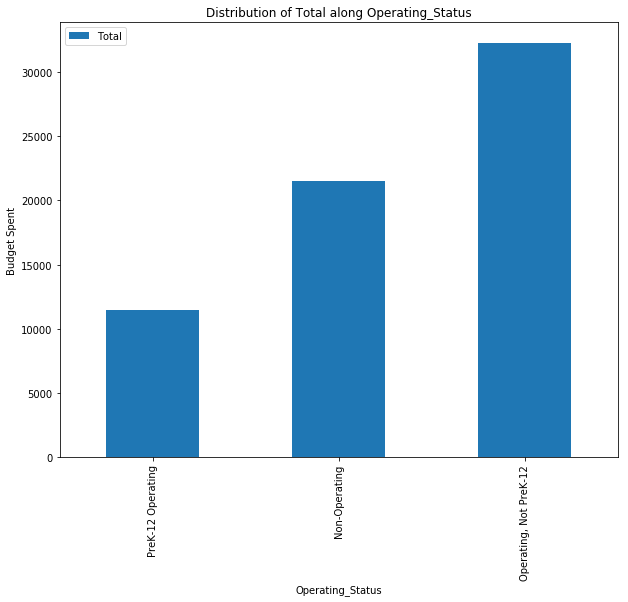

In [217]:
average_total=train[['Total', 'Operating_Status']].groupby(['Operating_Status'], as_index = True).mean().sort_values(by = 'Total')
average_total.plot.bar(figsize = (10,8))
plt.title('Distribution of Total along Operating_Status')
plt.ylabel('Budget Spent')
plt.show

From the above plot we can see that our Budget is highly skewed to the Operating, Not PreK-12 sub-category compared to the rest of the sub-categories.

<function matplotlib.pyplot.show>

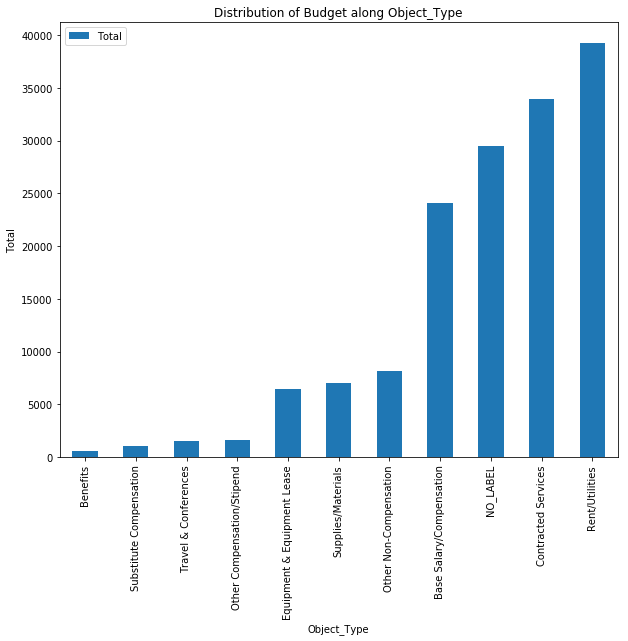

In [218]:
average_total=train[['Total', 'Object_Type']].groupby(['Object_Type'], as_index = True).mean().sort_values(by = 'Total')
average_total.plot.bar(figsize = (10,8))
plt.title('Distribution of Budget along Object_Type')
plt.ylabel('Total')
plt.show

<function matplotlib.pyplot.show>

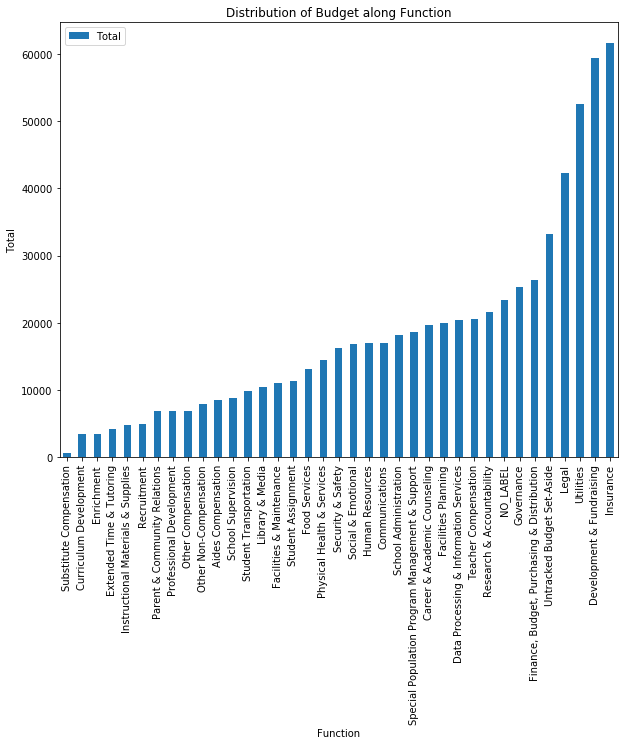

In [219]:
ave_total_func=train[['Total', 'Function']].groupby(['Function'], as_index = True).mean().sort_values(by = 'Total')
ave_total_func.plot.bar(figsize= (10,8))
plt.title('Distribution of Budget along Function')
plt.ylabel('Total')
plt.show

From the above plot, we can see that most of the school budget is spent on the Insurance, Development & Fundraising, Utilities, and Legal activities. Among these, Utilities is the only one that may directly affect the student learning experience. We can see that curriculum development, extended time and tutoring have the least budget spent. 
ERS (our host), really needs to focus on guiding its financial partners to understand their budget spent. We say so, as our host wants to improve student and teacher outcomes as well. 

# Data Cleaning

* In this step, We are removing the white strips and capitalizing our categorical variables 

In [220]:
train_trimmed = train.apply(lambda x: x.str.strip() if x.dtype == "object" else x) #change to category if ran 
#the cell which changes object to category
train_trimmed = train_trimmed.apply(lambda x: x.str.upper() if x.dtype == "object" else x)
train_trimmed.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1,index
0,TEACHER COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,NO_LABEL,TEACHER,NO_LABEL,NO_LABEL,PREK-12 OPERATING,NaN,...,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,GENERAL FUND,NaN,134338
1,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NON-OPERATING,CONTRACTOR SERVICES,...,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES,206341
2,TEACHER COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,TEACHER,BASE SALARY/COMPENSATION,NON PREK,PREK-12 OPERATING,PERSONAL SERVICES - TEACHERS,...,NaN,1.0,NaN,NaN,TEACHER,62237.130,INSTRUCTION - REGULAR,GENERAL PURPOSE SCHOOL,NaN,326408
3,SUBSTITUTE COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,SUBSTITUTE,BENEFITS,NO_LABEL,PREK-12 OPERATING,EMPLOYEE BENEFITS,...,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION,364634
4,SUBSTITUTE COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,TEACHER,SUBSTITUTE COMPENSATION,NO_LABEL,PREK-12 OPERATING,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION,47683


In [221]:
train_trim_set = train_trimmed.copy()[:100]
train_trim_set.head() #100 entries to work on

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1,index
0,TEACHER COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,NO_LABEL,TEACHER,NO_LABEL,NO_LABEL,PREK-12 OPERATING,NaN,...,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,GENERAL FUND,NaN,134338
1,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NON-OPERATING,CONTRACTOR SERVICES,...,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES,206341
2,TEACHER COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,TEACHER,BASE SALARY/COMPENSATION,NON PREK,PREK-12 OPERATING,PERSONAL SERVICES - TEACHERS,...,NaN,1.0,NaN,NaN,TEACHER,62237.130,INSTRUCTION - REGULAR,GENERAL PURPOSE SCHOOL,NaN,326408
3,SUBSTITUTE COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,SUBSTITUTE,BENEFITS,NO_LABEL,PREK-12 OPERATING,EMPLOYEE BENEFITS,...,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION,364634
4,SUBSTITUTE COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,TEACHER,SUBSTITUTE COMPENSATION,NO_LABEL,PREK-12 OPERATING,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION,47683


# Let's impute the numeric data

* To handle the null values in the numeric data, we had created a customized imputer function that was imputing the missing FTE and Total (Budget spent) based on sub-categories in our training set.
* On some research, we found a code that is inspired by SKlearn statsmodel library, [MICE module](http://www.statsmodels.org/dev/imputation.html#).
* [MICE.py](https://github.com/jeweinberg/Pandas-MICE) that we will implement in Phase 2 of our Final project.

MICE stands for Multiple Imputation with Chained Equations. We know that FTE and Total Budget are document specific, i.e. a full-time employee and a higher paid employee would not have the same role, designation, operation status, etc as a part-time employee hired on a contract basis. We cannot impute them by taking a mean or median of the entire dataset. Hence, we need a special imputation method that can use as much information as possible from the other features (independent variables) to impute depending on each document (employee) feature. 

## Using Pandas-MICE

In [98]:
train_imp = train_trimmed.drop(['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type',
       'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status'],axis=1)
train_imp.head()

,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1,index
0,NaN,NaN,NaN,TEACHER-ELEMENTARY,NaN,NaN,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,GENERAL FUND,NaN,134338
1,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(BLANK),REGULAR,NaN,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES,206341
2,PERSONAL SERVICES - TEACHERS,NaN,NaN,TCHER 2ND GRADE,NaN,REGULAR INSTRUCTION,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,INSTRUCTION - REGULAR,GENERAL PURPOSE SCHOOL,NaN,326408
3,EMPLOYEE BENEFITS,TEACHER SUBS,GENERAL FUND,"TEACHER, SHORT TERM SUB",REGULAR,NaN,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION,364634
4,TEACHER COVERAGE FOR TEACHER,TEACHER SUBS,GENERAL FUND,"TEACHER, SECONDARY (HIGH)",ALTERNATIVE,NaN,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION,47683


In [99]:
train_imp.isnull().sum()

Object_Description         24784
Text_2                    312060
SubFund_Description        93422
Job_Title_Description     107534
Text_3                    291125
Text_4                    346531
Sub_Object_Description    308674
Location_Description      238223
FTE                       274206
Function_Description       58082
Facility_or_Department    346391
Position_Extra            135513
Total                       4555
Program_Description        95617
Fund_Description          197400
Text_1                    107992
index                          0
dtype: int64

In [100]:
train_imp.shape

(400277, 17)

In [101]:
mice_imp = MiceImputer(seed_strategy='most_frequent')

In [102]:
import re
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in train_imp.columns:
    if train_imp[column_name].dtype == object:
      #  print("do_nothing")
        temp = train_imp[column_name].astype(str).map(lambda x: re.sub(r'\W+', '', x))        
        train_imp[column_name] = le.fit_transform(temp)
    else:
        pass

In [103]:
train_imp.head()

,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1,index
0,560,280,266,2740,34,235,165,347,1.0,639,172,255,50471.810,191,41,1370,134338
1,72,18,17,291,24,235,165,347,NaN,457,172,472,3477.860,49,137,141,206341
2,347,280,266,2365,34,146,165,347,1.0,639,172,440,62237.130,159,43,1370,326408
3,110,254,79,2915,24,235,165,347,NaN,618,172,351,22.300,131,137,1006,364634
4,492,254,79,2908,1,235,165,347,NaN,342,172,351,54.166,129,137,1006,47683


In [104]:
input_cat_columns = []
for column in train.columns:
    if (column not in cat_list) & (column != 'FTE') & (column != 'Total'):
        input_cat_columns.append(column)
input_cat_columns

['Object_Description',
 'Text_2',
 'SubFund_Description',
 'Job_Title_Description',
 'Text_3',
 'Text_4',
 'Sub_Object_Description',
 'Location_Description',
 'Function_Description',
 'Facility_or_Department',
 'Position_Extra',
 'Program_Description',
 'Fund_Description',
 'Text_1',
 'index']

Problem faced :</n>
The inverse_transform for labels do not work due to some new unmatched values in the encoded column(https://github.com/scikit-learn/scikit-learn/pull/9816)

Hence will concat the imputed numerical columns with categorical columns from original dataset


In [105]:
#for column_name in input_cat_columns:
#    print(column_name)
#    le.inverse_transform(train_imp[column_name].astype(object).tolist)

In [106]:
train_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400277 entries, 0 to 400276
Data columns (total 17 columns):
Object_Description        400277 non-null int64
Text_2                    400277 non-null int64
SubFund_Description       400277 non-null int64
Job_Title_Description     400277 non-null int64
Text_3                    400277 non-null int64
Text_4                    400277 non-null int64
Sub_Object_Description    400277 non-null int64
Location_Description      400277 non-null int64
FTE                       126071 non-null float64
Function_Description      400277 non-null int64
Facility_or_Department    400277 non-null int64
Position_Extra            400277 non-null int64
Total                     395722 non-null float64
Program_Description       400277 non-null int64
Fund_Description          400277 non-null int64
Text_1                    400277 non-null int64
index                     400277 non-null int64
dtypes: float64(2), int64(15)
memory usage: 51.9 MB


In [107]:
# from IPython.core.debugger import Pdb as pdb
# #%pdb on
# %debug

fitted_val = mice_imp.fit(train_imp)

In [108]:
miced_data = fitted_val.transform(train_imp)

In [109]:
miced_data.head()

,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1,index
0,560,280,266,2740,34,235,165,347,1.000000,639,172,255,50471.810,191,41,1370,134338
1,72,18,17,291,24,235,165,347,-0.008392,457,172,472,3477.860,49,137,141,206341
2,347,280,266,2365,34,146,165,347,1.000000,639,172,440,62237.130,159,43,1370,326408
3,110,254,79,2915,24,235,165,347,-0.120100,618,172,351,22.300,131,137,1006,364634
4,492,254,79,2908,1,235,165,347,0.058727,342,172,351,54.166,129,137,1006,47683


We see that our data has been imputed. Let's confirm we have no missing values after this.

In [110]:
miced_data.isnull().sum()

Object_Description        0
Text_2                    0
SubFund_Description       0
Job_Title_Description     0
Text_3                    0
Text_4                    0
Sub_Object_Description    0
Location_Description      0
FTE                       0
Function_Description      0
Facility_or_Department    0
Position_Extra            0
Total                     0
Program_Description       0
Fund_Description          0
Text_1                    0
index                     0
dtype: int64

## Merge after imputation

Let's merge it to the original data

In [111]:
subset_mice = miced_data[['FTE','Total','index']]
subset_mice.head() #keep selected columns

,FTE,Total,index
0,1.000000,50471.810,134338
1,-0.008392,3477.860,206341
2,1.000000,62237.130,326408
3,-0.120100,22.300,364634
4,0.058727,54.166,47683


In [112]:
train_trimmed_new = train_trimmed.drop(['FTE','Total'],axis=1)
train_trimmed_new.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Text_4,Sub_Object_Description,Location_Description,Function_Description,Facility_or_Department,Position_Extra,Program_Description,Fund_Description,Text_1,index
0,TEACHER COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,NO_LABEL,TEACHER,NO_LABEL,NO_LABEL,PREK-12 OPERATING,NaN,...,NaN,NaN,NaN,NaN,NaN,KINDERGARTEN,KINDERGARTEN,GENERAL FUND,NaN,134338
1,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NON-OPERATING,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES,206341
2,TEACHER COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,TEACHER,BASE SALARY/COMPENSATION,NON PREK,PREK-12 OPERATING,PERSONAL SERVICES - TEACHERS,...,REGULAR INSTRUCTION,NaN,NaN,NaN,NaN,TEACHER,INSTRUCTION - REGULAR,GENERAL PURPOSE SCHOOL,NaN,326408
3,SUBSTITUTE COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,SUBSTITUTE,BENEFITS,NO_LABEL,PREK-12 OPERATING,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION,364634
4,SUBSTITUTE COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,TEACHER,SUBSTITUTE COMPENSATION,NO_LABEL,PREK-12 OPERATING,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION,47683


In [113]:
train_merged = pd.merge(subset_mice,train_trimmed_new,how='outer', on='index')
train_merged.head()

,FTE,Total,index,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,...,Text_3,Text_4,Sub_Object_Description,Location_Description,Function_Description,Facility_or_Department,Position_Extra,Program_Description,Fund_Description,Text_1
0,1.000000,50471.810,134338,TEACHER COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,NO_LABEL,TEACHER,NO_LABEL,...,NaN,NaN,NaN,NaN,NaN,NaN,KINDERGARTEN,KINDERGARTEN,GENERAL FUND,NaN
1,-0.008392,3477.860,206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,...,REGULAR,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
2,1.000000,62237.130,326408,TEACHER COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,TEACHER,BASE SALARY/COMPENSATION,...,NaN,REGULAR INSTRUCTION,NaN,NaN,NaN,NaN,TEACHER,INSTRUCTION - REGULAR,GENERAL PURPOSE SCHOOL,NaN
3,-0.120100,22.300,364634,SUBSTITUTE COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,SUBSTITUTE,BENEFITS,...,REGULAR,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
4,0.058727,54.166,47683,SUBSTITUTE COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,TEACHER,SUBSTITUTE COMPENSATION,...,ALTERNATIVE,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


Looks great!

# Feature Importances

Now we will look at feature importance for each of our features. For this we are using RandomForestClassifier from sklearn.ensemble. For this purpose, we are using unsplitted data set with independent features and also unsplitted labels.

In [62]:
from sklearn.ensemble import RandomForestClassifier
forest_regModel = RandomForestClassifier(random_state=42, max_features=None)
forest_regModel.fit(miced_data, dummies_lab)

NameError: name 'dummies_lab' is not defined

In [ ]:
feature_importances = forest_regModel.feature_importances_
feature_importances

In [ ]:
attributes = ['Object_Description', 'Text_2', 'SubFund_Description','Job_Title_Description','Text_3',
             'Text_4','Sub_Object_Description','Location_Description','FTE','Function_Description',
             'Facility_or_Department','Position_Extra','Total','Program_Description','Fund_Description',
             'Text_1']

In [ ]:
sortedFeatures = sorted(zip(np.round(feature_importances,4), attributes), reverse=False)

In [ ]:
## Plot feature importances

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10)) 
plt.title("Feature importances")
sortedNames = np.array(sortedFeatures)[:, 1]
sortedImportances = np.array(sortedFeatures)[:, 0]

plt.title('Feature Importances', fontsize=16)
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.xticks(rotation='vertical', fontsize=14)
plt.yticks(range(len(sortedNames)), sortedNames, fontsize=14)
plt.xlabel('Relative Importance', fontsize=14)
plt.grid()
plt.show()

Looking at the output of feature imporatnces and also barplot we can see that Job_Description has the highest coefficient( 0.244), followed by Location_Description, Object_description, Fund_description, Program_Description and so on. Facility or Department is the least important feature of all. 

# Numerical pipeline 

Our numerical pipeline consists of FTE and Total. 

num_lab = ['FTE','Total']
numeric_train = miced_data[num_lab]
numeric_train.head()

#create dummies of our targets
dummies_lab1 = pd.get_dummies(train[cat_list])
dummies_lab = dummies_lab1.sort_index()
dummies_lab.head()

Numerical split-
numeric_train - X
dummies_lab - Y

X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_train,dummies_lab,
                                                               size=0.2,seed=143)

np.sum(X_train.isna())

y_train.info()

train.info() #Int64Index: 400277 entries, 134338 to 415831

#from sklearn.linear_model import LogisticRegression
#log_model = LogisticRegression()
#fit_x = log_model.fit(X_train,y_train)

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values 

#numeric pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_lab)),
        #('imputer', Imputer(strategy="median",missing_values=np.nan)),
        ('std_scaler', MinMaxScaler()),
    ])

num_pipeline.fit(X_train,y_train)

Numerical pipeline is ready.

# Categorical pipeline

In [ ]:
train_trimmed.shape

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        All = X[X.columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
        print(All.sort_index().head())
        #return np.c_[All.sort_index()]
        return All.sort_index()
        
        

In [ ]:
cat_train = train_trimmed.drop(['FTE','Total'], axis=1).drop(['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type',
       'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status'],axis=1)
cat_train.head()

In [ ]:
cat_train_lab = cat_train.columns
cat_train_lab

In [ ]:
#cat_pipeline = Pipeline(
          #  ('selector',DataFrameSelector(cat_train_lab)),
            #('imputer', CategoricalImputer()),
 #           )

In [ ]:
c = CategoricalImputer()

In [ ]:
extra_columns = c.transform(cat_train)

cat_train["All"] = extra_columns
cat_train.head()

In [ ]:
cat_train.shape

In [ ]:
cat_train["All"].head()

# Preparing the Data for ML algorithm

## Supporting Classes

### Splitting train and test


Since we are dealing with a multilabel, multiclass situation, we are going to split our training data set in a multi-stratified way. By that we mean we want to make sure all of our sub-categories are present in train and test set. 
If we don't use this custom train-test-split, we may run into issues where our train data has never seen some of the sub-categories and we know that this cannot be the case because we are performing supervised learning.

In [222]:
#source: https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/data/multilabel.py
from warnings import warn

import numpy as np
import pandas as pd

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])


### DataFrameSelector class

In [223]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values 

## Let's impute the numeric data

* To handle the null values in the numeric data, we had created a customized imputer function that was imputing the missing FTE and Total (Budget spent) based on sub-categories in our training set.
* On some research, we found a code that is inspired by SKlearn statsmodel library, [MICE module](http://www.statsmodels.org/dev/imputation.html#).
* [MICE.py](https://github.com/jeweinberg/Pandas-MICE) that we will implement in Phase 2 of our Final project.

MICE stands for Multiple Imputation with Chained Equations. We know that FTE and Total Budget are document specific, i.e. a full-time employee and a higher paid employee would not have the same role, designation, operation status, etc as a part-time employee hired on a contract basis. We cannot impute them by taking a mean or median of the entire dataset. Hence, we need a special imputation method that can use as much information as possible from the other features (independent variables) to impute depending on each document (employee) feature. 

### Using Pandas-MICE

In [11]:
train_imp = train_trimmed.drop(['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type',
       'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status'],axis=1)
train_imp.head()

,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,NaN,NaN,NaN,TEACHER-ELEMENTARY,NaN,NaN,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,GENERAL FUND,NaN
206341,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(BLANK),REGULAR,NaN,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,PERSONAL SERVICES - TEACHERS,NaN,NaN,TCHER 2ND GRADE,NaN,REGULAR INSTRUCTION,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,INSTRUCTION - REGULAR,GENERAL PURPOSE SCHOOL,NaN
364634,EMPLOYEE BENEFITS,TEACHER SUBS,GENERAL FUND,"TEACHER, SHORT TERM SUB",REGULAR,NaN,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,TEACHER COVERAGE FOR TEACHER,TEACHER SUBS,GENERAL FUND,"TEACHER, SECONDARY (HIGH)",ALTERNATIVE,NaN,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


In [151]:
train_imp.isnull().sum()

Object_Description         24784
Text_2                    312060
SubFund_Description        93422
Job_Title_Description     107534
Text_3                    291125
Text_4                    346531
Sub_Object_Description    308674
Location_Description      238223
FTE                       274206
Function_Description       58082
Facility_or_Department    346391
Position_Extra            135513
Total                       4555
Program_Description        95617
Fund_Description          197400
Text_1                    107992
dtype: int64

In [152]:
train_imp.shape

(400277, 16)

In [12]:
mice_imp = MiceImputer(seed_strategy='most_frequent')

In [13]:
import re
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in train_imp.columns:
    if train_imp[column_name].dtype == object:
      #  print("do_nothing")
        temp = train_imp[column_name].astype(str).map(lambda x: re.sub(r'\W+', '', x))        
        train_imp[column_name] = le.fit_transform(temp)
    else:
        pass

In [14]:
train_imp.head()

,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,560,280,266,2740,34,235,165,347,1.0,639,172,255,50471.810,191,41,1354
206341,72,18,17,291,24,235,165,347,NaN,457,172,472,3477.860,49,137,135
326408,347,280,266,2365,34,146,165,347,1.0,639,172,440,62237.130,159,43,1354
364634,110,254,79,2915,24,235,165,347,NaN,618,172,351,22.300,131,137,994
47683,492,254,79,2908,1,235,165,347,NaN,342,172,351,54.166,129,137,994


In [15]:
input_cat_columns = []
for column in train.columns:
    if (column not in cat_list) & (column != 'FTE') & (column != 'Total'):
        input_cat_columns.append(column)
#input_cat_columns

Problem faced :</n>
The inverse_transform for labels do not work due to some new unmatched values in the encoded column(https://github.com/scikit-learn/scikit-learn/pull/9816)

Hence will concat the imputed numerical columns with categorical columns from original dataset


In [157]:
#for column_name in input_cat_columns:
#    print(column_name)
#    le.inverse_transform(train_imp[column_name].astype(object).tolist)

In [16]:
train_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 16 columns):
Object_Description        400277 non-null int64
Text_2                    400277 non-null int64
SubFund_Description       400277 non-null int64
Job_Title_Description     400277 non-null int64
Text_3                    400277 non-null int64
Text_4                    400277 non-null int64
Sub_Object_Description    400277 non-null int64
Location_Description      400277 non-null int64
FTE                       126071 non-null float64
Function_Description      400277 non-null int64
Facility_or_Department    400277 non-null int64
Position_Extra            400277 non-null int64
Total                     395722 non-null float64
Program_Description       400277 non-null int64
Fund_Description          400277 non-null int64
Text_1                    400277 non-null int64
dtypes: float64(2), int64(14)
memory usage: 51.9 MB


In [17]:
# from IPython.core.debugger import Pdb as pdb
# #%pdb on
# %debug

fitted_val = mice_imp.fit(train_imp)

In [18]:
miced_data = fitted_val.transform(train_imp)

In [19]:
miced_data.head()

,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
2,344,280,266,3154,34,146,165,347,0.000000,639,172,432,141.57990,159,43,1354
3,336,280,266,3154,34,146,165,347,0.000000,639,172,80,1166.76000,159,43,1354
4,560,221,110,929,34,235,165,279,1.000000,639,172,481,33668.53737,416,137,1354
5,339,280,266,3154,34,123,165,78,0.000000,639,111,355,6285.45000,270,43,1354
8,395,280,41,3154,34,235,18,347,0.585395,343,172,481,-0.19000,416,113,134


We see that our data has been imputed. Let's confirm we have no missing values after this.

In [20]:
miced_data.isnull().sum()

Object_Description        0
Text_2                    0
SubFund_Description       0
Job_Title_Description     0
Text_3                    0
Text_4                    0
Sub_Object_Description    0
Location_Description      0
FTE                       0
Function_Description      0
Facility_or_Department    0
Position_Extra            0
Total                     0
Program_Description       0
Fund_Description          0
Text_1                    0
dtype: int64

Looks great!

### Wrapper for Imputation

In [409]:
class SelfImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputed_attrib_names, attrib_names, datatype, seed_strategy='most_frequent'):
        ## seed_strategy : strategy for imputation, set to 'most_frequent' as default
        ## imputed_attrib_name : columns which should be picked from the imputed data, here 'FTE' & 'TOTAL'. 
        ##                           Rest will be used for imputation however we should return the df 
        ##                               with only imputed_attrib_name columns changed
        
        self.imputed_attrib_names = imputed_attrib_names
        self.attrib_names = attrib_names
        self.seed_strategy = seed_strategy
        self.datatype = datatype
        ##self.attrib_names.append('index')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Create a copy of the input df to work with
        self.X = pd.DataFrame(X, columns=self.attrib_names, dtype=object)
        self.X.FTE = self.X.FTE.astype(float)
        self.X.Total = self.X.Total.astype(float)
        self.X['index'] = pd.to_numeric(self.X['index'])
    
        
        #print(self.X.info())
        #temporary df- need not remove if no time
        self.X_imp = self.X.copy()
        
        mice_imp = MiceImputer(seed_strategy=self.seed_strategy)
        le = preprocessing.LabelEncoder()
        for column_name in self.X_imp.columns:
            if self.X_imp[column_name].dtype == object:
              #  removing characters other than alphabets
                temp = self.X_imp[column_name].astype(str).map(lambda x: re.sub(r'\W+', '', x))        
                self.X_imp[column_name] = le.fit_transform(temp)
            else:
                pass
        #print(self.X_imp.info())
        #fit the model for imputation
        # transform the copy of input df and imput missing 
        miced_data = mice_imp.fit(self.X_imp).transform(self.X_imp)
        
        
        ## Reconstructing the input df with only the imputed_attrib_names columns changed
        
        self.X = self.X.drop(columns=['FTE','Total'])  # drop 'FTE' and 'Total'
        print(self.X.info())
        
        self.imputed_attrib_names.append('index') # need to extract 'FTE', 'Total' and 'index' columns from imputed data
        miced_data_subset = miced_data[['FTE','Total','index']]
        print (miced_data_subset.info())
        self.X = pd.merge(self.X,miced_data_subset,how='outer', on='index')
        print(self.X.head())
        return self.X.values 
    


### Create pipeline for MICE imputation

In [410]:
num_attribs = ['Object_Description','Text_2','SubFund_Description','Job_Title_Description',
                      'Text_3','Text_4','Sub_Object_Description','Location_Description','FTE',
                      'Function_Description','Facility_or_Department','Position_Extra','Total',
                      'Program_Description','Fund_Description','Text_1','index']
num_impute_attribs = ['FTE','Total']
datatype = np.dtype([('Object_Description',object),('Text_2',object),('SubFund_Description',object),('Job_Title_Description',object),('Text_3',object),('Text_4',object),('Sub_Object_Description',object),('Location_Description',object),('FTE',float),('Function_Description',object),('Facility_or_Department',object),('Position_Extra',object),('Total',float),('Program_Description',object),('Fund_Description',object),('Text_1',object),('index',int)])
#datatype = np.dtype([(object,object,object,object,object,object,object,object,float,object,object,object,float,object,object,object,int)])

num_impute_pipeline =  Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SelfImputer(num_impute_attribs,num_attribs,datatype,seed_strategy="most_frequent")),
       # ('std_scaler', StandardScaler()),
    ])


#### test Imputer pipeline

In [404]:
train_trimmed.dtypes


Function                   object
Use                        object
Sharing                    object
Reporting                  object
Student_Type               object
Position_Type              object
Object_Type                object
Pre_K                      object
Operating_Status           object
Object_Description         object
Text_2                     object
SubFund_Description        object
Job_Title_Description      object
Text_3                     object
Text_4                     object
Sub_Object_Description     object
Location_Description       object
FTE                       float64
Function_Description       object
Facility_or_Department     object
Position_Extra             object
Total                     float64
Program_Description        object
Fund_Description           object
Text_1                     object
index                       int64
dtype: object

In [405]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400277 entries, 0 to 400276
Data columns (total 26 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Function_

In [411]:
num_impute_pipeline.fit(train)

Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['Object_Description', 'Text_2', 'SubFund_Description', 'Job_Title_Description', 'Text_3', 'Text_4', 'Sub_Object_Description', 'Location_Description', 'FTE', 'Function_Description', 'Facility_or_Department', 'Position_Extra', 'Total', 'Program_De...), ('index', '<i4')]),
      imputed_attrib_names=['FTE', 'Total'], seed_strategy='most_frequent'))])

In [412]:
train_imp = num_impute_pipeline.transform(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400277 entries, 0 to 400276
Data columns (total 15 columns):
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
Function_Description      342195 non-null object
Facility_or_Department    53886 non-null object
Position_Extra            264764 non-null object
Program_Description       304660 non-null object
Fund_Description          202877 non-null object
Text_1                    292285 non-null object
index                     400277 non-null int64
dtypes: int64(1), object(14)
memory usage: 45.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 0 to 400276
Data columns (total 3 co

In [414]:
train.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1,index
0,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN,134338
1,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES,206341
2,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN,326408
3,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION,364634
4,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION,47683


In [413]:
train_imp[:5]

array([[nan, nan, nan, 'Teacher-Elementary ', nan, nan, nan, nan, nan,
        nan, 'KINDERGARTEN ', 'KINDERGARTEN', 'General Fund', nan,
        134338, 1.0, 50471.81],
       ['CONTRACTOR SERVICES', 'BOND EXPENDITURES', 'BUILDING FUND',
        '(blank)', 'Regular', nan, nan, nan, 'RGN  GOB', nan,
        'UNDESIGNATED', 'BUILDING IMPROVEMENT SERVICES', nan,
        'BUILDING IMPROVEMENT SERVICES', 206341, -0.28351706147038563,
        3477.86],
       ['Personal Services - Teachers', nan, nan, 'TCHER 2ND GRADE', nan,
        'Regular Instruction', nan, nan, nan, nan, 'TEACHER',
        'Instruction - Regular', 'General Purpose School', nan, 326408,
        1.0, 62237.13000000001],
       ['EMPLOYEE BENEFITS', 'TEACHER SUBS', 'GENERAL FUND',
        'Teacher, Short Term Sub ', 'Regular', nan, nan, nan,
        'UNALLOC BUDGETS/SCHOOLS', nan, 'PROFESSIONAL-INSTRUCTIONAL',
        'GENERAL MIDDLE/JUNIOR HIGH SCH', nan, 'REGULAR INSTRUCTION',
        364634, -0.15771450455854497, 22.3],

## Numerical pipeline -OHE of target

Our numerical pipeline consists of FTE and Total. 

In [21]:
num_lab = ['FTE','Total']
numeric_train = miced_data[num_lab]
numeric_train.head()

,FTE,Total
2,0.000000,141.57990
3,0.000000,1166.76000
4,1.000000,33668.53737
5,0.000000,6285.45000
8,0.585395,-0.19000


In [22]:
#create dummies of our targets
dummies_lab1 = pd.get_dummies(train[cat_list])
dummies_lab = dummies_lab1.sort_index()
dummies_lab.head()

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


Numerical split-
numeric_train - X
dummies_lab - Y

In [25]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_train,dummies_lab,
                                                               size=0.2,seed=143)

In [166]:
np.sum(X_train.isna())

FTE      0
Total    0
dtype: int64

In [167]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 2 to 450340
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 34.2 MB


In [168]:
train.info() #Int64Index: 400277 entries, 134338 to 415831

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

In [38]:
#from sklearn.linear_model import LogisticRegression
#log_model = LogisticRegression()
#fit_x = log_model.fit(X_train,y_train)

In [27]:
#numeric pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_lab)),
        #('imputer', Imputer(strategy="median",missing_values=np.nan)),
        ('std_scaler', MinMaxScaler()),
    ])

In [28]:
num_pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['FTE', 'Total'])), ('std_scaler', MinMaxScaler(copy=True, feature_range=(0, 1)))])

Numerical pipeline is ready.

# Classification Model

## Logging the Result

In [35]:
results = pd.DataFrame(columns=["Model", "Hyper parameter tuning", "Test Accuracy"])

## Create complete dataset with imputed columns and added features

In [37]:
numeric_train.head()

,FTE,Total
2,0.000000,141.57990
3,0.000000,1166.76000
4,1.000000,33668.53737
5,0.000000,6285.45000
8,0.585395,-0.19000


In [43]:
cat_train.head()

,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,Function_Description,Facility_or_Department,Position_Extra,Program_Description,Fund_Description,Text_1,All
134338,NaN,NaN,NaN,TEACHER-ELEMENTARY,NaN,NaN,NaN,NaN,NaN,NaN,KINDERGARTEN,KINDERGARTEN,GENERAL FUND,NaN,nan nan nan TEACHER-ELEMENTARY nan nan nan nan...
206341,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(BLANK),REGULAR,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES,CONTRACTOR SERVICES BOND EXPENDITURES BUILDING...
326408,PERSONAL SERVICES - TEACHERS,NaN,NaN,TCHER 2ND GRADE,NaN,REGULAR INSTRUCTION,NaN,NaN,NaN,NaN,TEACHER,INSTRUCTION - REGULAR,GENERAL PURPOSE SCHOOL,NaN,PERSONAL SERVICES - TEACHERS nan nan TCHER 2ND...
364634,EMPLOYEE BENEFITS,TEACHER SUBS,GENERAL FUND,"TEACHER, SHORT TERM SUB",REGULAR,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION,EMPLOYEE BENEFITS TEACHER SUBS GENERAL FUND TE...
47683,TEACHER COVERAGE FOR TEACHER,TEACHER SUBS,GENERAL FUND,"TEACHER, SECONDARY (HIGH)",ALTERNATIVE,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION,TEACHER COVERAGE FOR TEACHER TEACHER SUBS GENE...


In [38]:

df1 = numeric_train.sort_index()  # Data from numeric pipeline
df2 = cat_train.sort_index()      # Data from categoric pipeline
df3 = train_trimmed.sort_index().drop(num_lab,axis=1) # Target columns
miced_data_invtransform = pd.concat([df3,df1,df2], axis=1)
miced_data_invtransform.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Text_4,Sub_Object_Description,Location_Description,Function_Description,Facility_or_Department,Position_Extra,Program_Description,Fund_Description,Text_1,All
2,SUBSTITUTE COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,SUBSTITUTE,SUBSTITUTE COMPENSATION,NON PREK,PREK-12 OPERATING,PERSONAL SERVICES - SUBSTITUTE TEACHERS CERTIFIED,...,REGULAR INSTRUCTION,NaN,NaN,NaN,NaN,SUBSTITUTE TEACHER,INSTRUCTION - REGULAR,GENERAL PURPOSE SCHOOL,NaN,PERSONAL SERVICES - SUBSTITUTE TEACHERS CERTIF...
3,TEACHER COMPENSATION,INSTRUCTION,SCHOOL REPORTED,SCHOOL,UNSPECIFIED,TEACHER,OTHER COMPENSATION/STIPEND,NON PREK,PREK-12 OPERATING,PERSONAL SERVICES - OTHER COMPENSATION,...,REGULAR INSTRUCTION,NaN,NaN,NaN,NaN,CAREER LADDER I/EXT LEARNING,INSTRUCTION - REGULAR,GENERAL PURPOSE SCHOOL,NaN,PERSONAL SERVICES - OTHER COMPENSATION nan nan...
4,AIDES COMPENSATION,INSTRUCTION,SCHOOL ON CENTRAL BUDGETS,NON-SCHOOL,SPECIAL EDUCATION,TA,BASE SALARY/COMPENSATION,NO_LABEL,PREK-12 OPERATING,NaN,...,NaN,NaN,SCHOOL SUPPORT,NaN,NaN,NaN,NaN,NaN,NaN,nan SPECIAL EDUCATION INSTRUCTION LOCAL EDUCAT...
5,SOCIAL & EMOTIONAL,PUPIL SERVICES & ENRICHMENT,SCHOOL ON CENTRAL BUDGETS,NON-SCHOOL,UNSPECIFIED,PSYCHOLOGIST,BASE SALARY/COMPENSATION,NON PREK,PREK-12 OPERATING,PERSONAL SERVICES - PSYCHOLOGISTS,...,OTHER STUDENT SUPPORT,NaN,DISTRICT WIDE RESOURCES,NaN,PSYCHOLOGICAL SERVICES,PSYCHOLOGICAL,PRINCIPAL'S OFFICE,GENERAL PURPOSE SCHOOL,NaN,PERSONAL SERVICES - PSYCHOLOGISTS nan nan nan ...
8,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NON-OPERATING,REGULAR *,...,NaN,CERTIFICATED EMPLOYEES SALARIES AND WAGES,NaN,NON-PUBLIC SCHOOL SERVICES *,NaN,NaN,NaN,TITLE I - DISADVANTAGED CHILDREN/TARGETED ASSI...,BUILDING ALLOCATIONS,REGULAR * nan COMMUNITY SERVICES nan nan nan C...


In [39]:
miced_data_invtransform.shape

(400277, 40)

In [40]:
miced_data_invtransform.isnull().sum()

Function                       0
Use                            0
Sharing                        0
Reporting                      0
Student_Type                   0
Position_Type                  0
Object_Type                    0
Pre_K                          0
Operating_Status               0
Object_Description         24784
Text_2                    312060
SubFund_Description        93422
Job_Title_Description     107534
Text_3                    291125
Text_4                    346531
Sub_Object_Description    308674
Location_Description      238223
Function_Description       58082
Facility_or_Department    346391
Position_Extra            135513
Program_Description        95617
Fund_Description          197400
Text_1                    107992
FTE                            0
Total                          0
Object_Description         24784
Text_2                    312060
SubFund_Description        93422
Job_Title_Description     107534
Text_3                    291125
Text_4    

## Trials with predicting accuracy for One Label at a time

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [42]:
miced_data_invtransform['All'].head()

2    PERSONAL SERVICES - SUBSTITUTE TEACHERS CERTIF...
3    PERSONAL SERVICES - OTHER COMPENSATION nan nan...
4    nan SPECIAL EDUCATION INSTRUCTION LOCAL EDUCAT...
5    PERSONAL SERVICES - PSYCHOLOGISTS nan nan nan ...
8    REGULAR * nan COMMUNITY SERVICES nan nan nan C...
Name: All, dtype: object

In [44]:
# split data into a trainin set (70%), validation set (15%) and blind (holdout) test set (15%)
df_train, df_other = train_test_split(miced_data_invtransform, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_other, test_size=0.5, random_state=42)

### Using OneVsRestClassifier - MultinomialNB

<u><b> OneVsRestClassifier </b></u>
This algorithm compares every class with all the remaining classes, building a model for every class. If you have ten classes to guess, you have ten models. This approach relies on the OneVsRestClassifier class from Scikit-learn.

In [46]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [49]:
NB_pipeline.fit(df_train['All'], df_train['Function'])

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...assifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=1))])

In [196]:
prediction = NB_pipeline.predict(df_val['All'])
print('Test accuracy is {}'.format( accuracy_score(df_val['Function'], prediction)))

Test accuracy is 0.853719063322341


In [203]:
results.loc[len(results)] = ["OneVsRest(MultiNB) - for Function Category", "default", np.round(0.853719063322341, 3)]
results

,Model,Hyper parameter tuning,Test Accuracy
0,OneVsRest(MultiNB) - for Function Category,default,0.854


In [197]:
prediction

array(['TEACHER COMPENSATION', 'INSTRUCTIONAL MATERIALS & SUPPLIES',
       'STUDENT TRANSPORTATION', ..., 'TEACHER COMPENSATION',
       'SCHOOL ADMINISTRATION', 'INSTRUCTIONAL MATERIALS & SUPPLIES'],
      dtype='<U47')

### Accuracy for all categories

In [198]:
for category in cat_list:
    NB_pipeline.fit(df_train['all'], df_train[category])
    prediction = NB_pipeline.predict(df_val['all'])
    print('Category {} : Test accuracy is {}'.format(category, np.round(accuracy_score(df_val[category], prediction),2)))

Category Function : Test accuracy is 0.85
Category Use : Test accuracy is 0.89
Category Sharing : Test accuracy is 0.89
Category Reporting : Test accuracy is 0.92
Category Student_Type : Test accuracy is 0.91
Category Position_Type : Test accuracy is 0.88
Category Object_Type : Test accuracy is 0.92
Category Pre_K : Test accuracy is 0.97
Category Operating_Status : Test accuracy is 0.96


In [204]:
results.loc[len(results)] = ["OneVsRest(MultiNB) - Avg All Category", "default", np.round(np.average((0.85,0.89,0.89,0.92,0.91,0.88,0.92,0.97,0.96)), 3)]
results

,Model,Hyper parameter tuning,Test Accuracy
0,OneVsRest(MultiNB) - for Function Category,default,0.854
1,OneVsRest(MultiNB) - Avg All Category,default,0.910


### Using OneVsRestClassifier - Logistic Regression

In [199]:
LR_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

In [200]:
for category in cat_list:
    LR_pipeline.fit(df_train['all'], df_train[category])
    prediction = LR_pipeline.predict(df_val['all'])
    print('Category {} : Test accuracy is {}'.format(category, np.round(accuracy_score(df_val[category], prediction),2)))

Category Function : Test accuracy is 0.95
Category Use : Test accuracy is 0.96
Category Sharing : Test accuracy is 0.96
Category Reporting : Test accuracy is 0.97
Category Student_Type : Test accuracy is 0.97
Category Position_Type : Test accuracy is 0.97
Category Object_Type : Test accuracy is 0.98
Category Pre_K : Test accuracy is 0.99
Category Operating_Status : Test accuracy is 0.98


In [205]:
results.loc[len(results)] = ["OneVsRest(LogisticRegression) - Avg All Category", "default", np.round(np.average((0.95,0.96,0.96,0.97,0.97,0.97,0.98,0.99,0.98)), 3)]
results

,Model,Hyper parameter tuning,Test Accuracy
0,OneVsRest(MultiNB) - for Function Category,default,0.854
1,OneVsRest(MultiNB) - Avg All Category,default,0.910
2,OneVsRest(LogisticRegression) - Avg All Category,default,0.970


In [216]:
model = LR_pipeline.named_steps["clf"]
model.coef_.shape

(3, 51938)

# Significant Testing

In [1]:
## still need to work on this

In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# A sampling based bakeoff using *K-fold cross-validation*: 

# this bakeoff framework can be used for regression or classification
#Control system is a logistic Regression with OneVsClassifier
scores1 =[]
#kFolds=10
#LR_clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
LR_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in cat_list:
    LR_pipeline.fit(df_train['All'], df_train[category])
    prediction = LR_pipeline.predict(df_val['All'])
    accuracy1 = accuracy_score(prediction, df_val[category])
    scores1.append(accuracy)   

control = average_accuracy1 =scores.mean()
display_scores(average_accuracy)

#Treatment system is a Random Forest Classifier based 
scores2
#rf_clf = RandomForestRegressor(random_state=42)
for category in cat_list:
    NB_pipeline.fit(df_train['All'], df_train[category])
    prediction = NB_pipeline.predict(df_val['All'])
    accuracy2 = accuracy_score(prediction, df_val[category])
    scores2.append(accuracy)   
treatment = average_accuracy2 =scores2.mean()
display_scores(average_accuracy2)

#paired t-test; two-tailed p-value (aka two-sided)
(t_score, p_value) = stats.ttest_rel(control, treatment)
print("The p-value is %0.5f for a t-score of %0.5f." %(p_value, t_score))
#"The p-value is 0.00019 for a t-score of -4.28218." 
if pvalue > 0.05/2:  #Two sided 
    print('There is no significant difference between the two machine learning pipelines (Accept H0)')
else:
    print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
    if t_score < 0.0:
        print('Machine learning pipeline A is better than B')
    else:
        print('Machine learning pipeline B is better than A')

NameError: name 'accuracy' is not defined

# Hyperparamter Tuning 
 (GRIDSEARCH)